# Notebook for Geographically Weighted Regression

Based on example notebook: https://github.com/pysal/mgwr

- Spatial regression technique that accounts for heterogeneity of satial data
- Fits regression to every feature in the dataset
- Produces mutliple local coefficients (unlike OLS which produces one)

In [38]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [173]:
dat_dir = r'C:\Users\pfanderi\OneDrive - National Energy Technology Laboratory\NRAP_Well_Integrity_Data_Studies\1_data'

# wells = pd.read_csv(os.path.join(dat_dir,'co_scp_data\watt_wells_combined_data_tested_25.csv'))
sections = pd.read_csv(os.path.join(dat_dir,'Section_w_Categorical_Data.csv'))
sections_gdf = gpd.read_file(os.path.join(dat_dir,'BLM_CO_PLSS_Township_SHP\BLM_CO_PLSS_FirstDivision\BLM_CO_PLSS_FirstDivision_20211217 selection.shp'))

In [174]:
sections.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'sec_id', 'Count_wells_x',
       'Operator Alias (Legacy)_BAYSWATER_sum',
       'Operator Alias (Legacy)_BONANZA CREEK ENERGY_sum',
       'Operator Alias (Legacy)_CRESTONE PEAK RESOURCES OPERATING LLC_sum',
       'Operator Alias (Legacy)_EXTRACTION OIL & GAS LLC_sum',
       'Operator Alias (Legacy)_GREAT WESTERN OPERATING_sum',
       'Operator Alias (Legacy)_HIGHPOINT OPERATING CO., INC._sum',
       ...
       'RECRDAREAN_std', 'SHAPE_STAr_sum', 'SHAPE_STAr_mean', 'SHAPE_STAr_std',
       'SHAPE_STLe_sum', 'SHAPE_STLe_mean', 'SHAPE_STLe_std', 'sec_id_sum',
       'sec_id_mean', 'sec_id_std'],
      dtype='object', length=1079)

<AxesSubplot:>

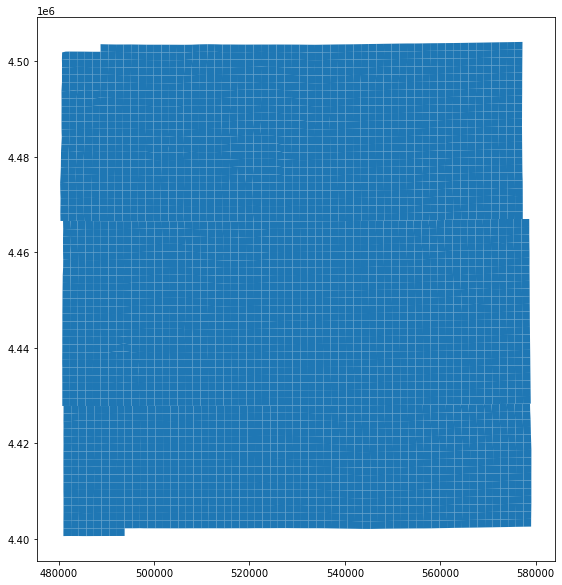

In [175]:
fig, ax = plt.subplots(figsize=(10,10))
sections_gdf.plot(ax=ax)

<AxesSubplot:>

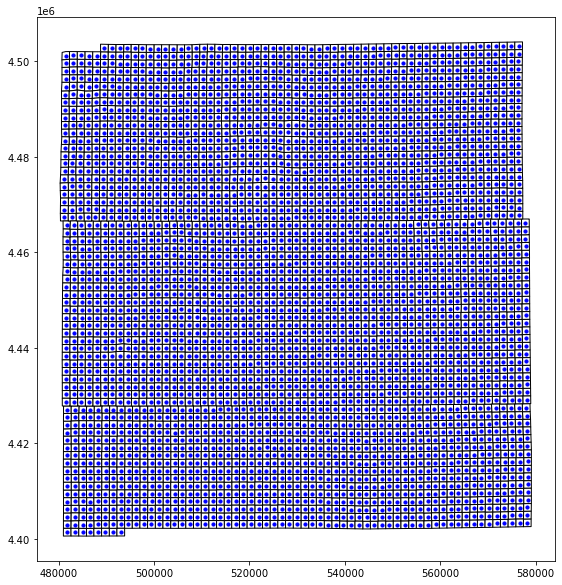

In [176]:
fig, ax = plt.subplots(figsize=(10,10))
sections_gdf.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
sections_gdf.centroid.plot(ax=ax, c='blue', markersize =10)

### Prepare Variables

Dropping all nans here, could consider imputation

Warning comes up when I don't filter for Percent UC Prod Csg Cemented_mean not null

In [195]:
# Filtering out nans for fields of interest
sections_clean = sections[sections['Count_wells_x'].notna()]
sections_clean = sections_clean[sections_clean['Closest Well with SCP or CVF Distance (ft)_mean'].notna()]
sections_clean = sections_clean[sections_clean['No Tested Wells Nearby (1 mi)_mean'].notna()]
sections_clean = sections_clean[sections_clean['Surface Casing Sealed_mean'].notna()]
sections_clean = sections_clean[sections_clean['Percent UC Prod Csg Cemented_mean'].notna()]
sections_clean = sections_clean[sections_clean['Closest Fault Distance (ft)_mean'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_BAYSWATER_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_BONANZA CREEK ENERGY_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_CRESTONE PEAK RESOURCES OPERATING LLC_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_EXTRACTION OIL & GAS LLC_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_GREAT WESTERN OPERATING_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_HIGHPOINT OPERATING CO., INC._sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_K P KAUFFMAN CO INC_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_KERR-MCGEE_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_NOBLE ENERGY_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_PDC ENERGY_sum'].notna()]
sections_clean = sections_clean[sections_clean['Operator Alias (Legacy)_SMALL OPERATOR_sum'].notna()]

sections_clean

,Unnamed: 0,Unnamed: 0.1,sec_id,Count_wells_x,Operator Alias (Legacy)_BAYSWATER_sum,Operator Alias (Legacy)_BONANZA CREEK ENERGY_sum,Operator Alias (Legacy)_CRESTONE PEAK RESOURCES OPERATING LLC_sum,Operator Alias (Legacy)_EXTRACTION OIL & GAS LLC_sum,Operator Alias (Legacy)_GREAT WESTERN OPERATING_sum,"Operator Alias (Legacy)_HIGHPOINT OPERATING CO., INC._sum",...,RECRDAREAN_std,SHAPE_STAr_sum,SHAPE_STAr_mean,SHAPE_STAr_std,SHAPE_STLe_sum,SHAPE_STLe_mean,SHAPE_STLe_std,sec_id_sum,sec_id_mean,sec_id_std
3,3,3,3,26.0,0.0,1.0,3.0,3.0,1.0,0.0,...,0.0,6.654366e+07,2.559372e+06,0.0,166381.265707,6399.279450,0.0,78.0,3.0,0.0
5,5,5,5,13.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,3.351170e+07,2.577823e+06,0.0,83489.714094,6422.285700,0.0,65.0,5.0,0.0
8,8,8,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2.615471e+06,2.615471e+06,NaN,6465.791204,6465.791204,NaN,8.0,8.0,NaN
9,9,9,9,13.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,3.366423e+07,2.589556e+06,0.0,83678.661143,6436.820088,0.0,117.0,9.0,0.0
10,10,10,10,28.0,0.0,1.0,0.0,0.0,3.0,0.0,...,0.0,7.310015e+07,2.610720e+06,0.0,180864.354462,6459.441231,0.0,280.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,3805,3805,3805,9.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,2.331079e+07,2.590088e+06,0.0,57938.477861,6437.608651,0.0,34245.0,3805.0,0.0
3807,3807,3807,3807,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,2.571091e+06,2.571091e+06,NaN,6414.005166,6414.005166,NaN,3807.0,3807.0,NaN
3808,3808,3808,3808,10.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,2.587111e+07,2.587111e+06,0.0,64338.041690,6433.804169,0.0,38080.0,3808.0,0.0
3812,3812,3812,3812,11.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,2.843219e+07,2.584744e+06,0.0,70740.473065,6430.952097,0.0,41932.0,3812.0,0.0


In [196]:
sections_y = sections_clean['SCP and/or CVF_mean'].values.reshape((-1,1))
sections_y.shape
np.isnan(sections_y).sum()

0

In [197]:
sections_x = sections_clean[['Closest Well with SCP or CVF Distance (ft)_mean','No Tested Wells Nearby (1 mi)_mean','Surface Casing Sealed_mean','Percent UC Prod Csg Cemented_mean', 'Closest Fault Distance (ft)_mean', 'Operator Alias (Legacy)_BAYSWATER_sum', 'Operator Alias (Legacy)_BONANZA CREEK ENERGY_sum', 'Operator Alias (Legacy)_CRESTONE PEAK RESOURCES OPERATING LLC_sum', 'Operator Alias (Legacy)_EXTRACTION OIL & GAS LLC_sum', 'Operator Alias (Legacy)_GREAT WESTERN OPERATING_sum', 'Operator Alias (Legacy)_HIGHPOINT OPERATING CO., INC._sum', 'Operator Alias (Legacy)_K P KAUFFMAN CO INC_sum', 'Operator Alias (Legacy)_KERR-MCGEE_sum', 'Operator Alias (Legacy)_NOBLE ENERGY_sum', 'Operator Alias (Legacy)_PDC ENERGY_sum', 'Operator Alias (Legacy)_SMALL OPERATOR_sum']].values

In [198]:
sections_x[0:5]
sections_x
np.isnan(sections_x).sum()

0

In [199]:
sections_gdf.centroid
sections_clean['sec_id']

sections_gdf['sec_id'] = range(0,3823)
sections_gdf

sections_gdf_clean = sections_gdf[sections_gdf['sec_id'].isin(sections_clean['sec_id'])]
sections_gdf_clean.centroid.x

sections_coords = list(zip(sections_gdf_clean.centroid.x,sections_gdf_clean.centroid.y))

### Calibrate GWR model

In [200]:
gwr_selector = Sel_BW(sections_coords, sections_y, sections_x)
gwr_bw = gwr_selector.search(bw_min=2)
gwr_bw

304.0

In [183]:
gwr_results = GWR(sections_coords, sections_y, sections_x, gwr_bw).fit()

In [170]:
gwr_results.params[0:5]

array([[ 1.24878815e+00, -3.00051563e-04, -5.51115025e-03,
        -6.81438310e-02, -2.62891586e-05, -1.01745139e-05,
        -7.36710104e-03, -9.22771641e-03,  1.22856549e-02,
         1.42906210e-02, -2.23059376e-02, -1.90206650e-02,
         4.55573495e-03, -3.02300389e-03, -7.31858897e-03,
         4.33814544e-03, -1.45124798e-02],
       [ 5.49661801e-01, -9.17998426e-05, -3.34548639e-03,
         7.78765392e-02, -6.16616728e-05,  1.63725143e-05,
        -1.21593888e-02,  1.81465585e-02, -2.91236113e-02,
         5.18739229e-04, -5.05795210e-03,  1.94533160e-02,
         1.10195755e-02,  4.23272191e-03, -7.14202015e-03,
         5.47826807e-03, -5.79024654e-03],
       [ 8.89496827e-01, -1.06473479e-04, -5.06335563e-03,
         1.96916507e-01, -5.35815192e-06, -1.49572904e-05,
         2.62319365e-02,  4.27827244e-02, -3.14002462e-02,
        -9.50744194e-03, -4.90734517e-03,  7.18046531e-03,
         1.21194248e-02, -7.13992298e-03,  1.09703893e-02,
        -1.35803638e-02,  4.6

In [171]:
gwr_results.localR2[0:5]

array([[0.76460002],
       [0.58860665],
       [0.53916004],
       [0.70923534],
       [0.65636016]])

In [172]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1504
Number of covariates:                                                    17

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            107.435
Log-likelihood:                                                    -149.557
AIC:                                                                333.115
AICc:                                                               335.575
BIC:                                                             -10771.284
R2:                                                                   0.178
Adj. R2:                                                              0.169

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Akaike information criterion (AIC): estimation of prediction error

    - AIC=2k-2ln(L)
    - k: number of estimated parameters in the model
    - L: maximum value of the likelihood function for the model
    
R2: (0-100): percent of variation explained by independent variables
    
    - R^2 = 1 - (RSS)(TSS)
    - RSS: sum of squares of residuals
    - TSS:total sum of squares

### Show results in maps

In [139]:
# Add GWR parameters to GeoDataframe
sections_gdf_clean['gwr_x0'] = gwr_results.params[:,0]
sections_gdf_clean['gwr_x1'] = gwr_results.params[:,1]
sections_gdf_clean['gwr_x2'] = gwr_results.params[:,2]
sections_gdf_clean['gwr_x3'] = gwr_results.params[:,3]
sections_gdf_clean['gwr_x4'] = gwr_results.params[:,4]
sections_gdf_clean['gwr_x5'] = gwr_results.params[:,5]
sections_gdf_clean['gwr_x6'] = gwr_results.params[:,6]
sections_gdf_clean['gwr_x7'] = gwr_results.params[:,7]
sections_gdf_clean['gwr_x8'] = gwr_results.params[:,8]
sections_gdf_clean['gwr_x9'] = gwr_results.params[:,9]
sections_gdf_clean['gwr_x10'] = gwr_results.params[:,10]
sections_gdf_clean['gwr_x11'] = gwr_results.params[:,11]
sections_gdf_clean['gwr_x12'] = gwr_results.params[:,12]
sections_gdf_clean['gwr_x13'] = gwr_results.params[:,13]
sections_gdf_clean['gwr_x14'] = gwr_results.params[:,14]
sections_gdf_clean['gwr_x15'] = gwr_results.params[:,15]
sections_gdf_clean['gwr_x16'] = gwr_results.params[:,16]

C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [140]:
# Obtain t-values filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [141]:
gwr_filtered_t[0:5]

array([[ 17.08528428, -17.004799  ,  -3.70838194,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [ 10.60199446, -11.61033615,   0.        ,   0.        ,
          0.        ,   4.3770571 ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [ 16.35448608, -10.86660875,  -3.79276957,   3.69617366,
          0.        ,  -3.49952865,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  8.62842974, -12.18825191,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,

C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\mgwr\utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


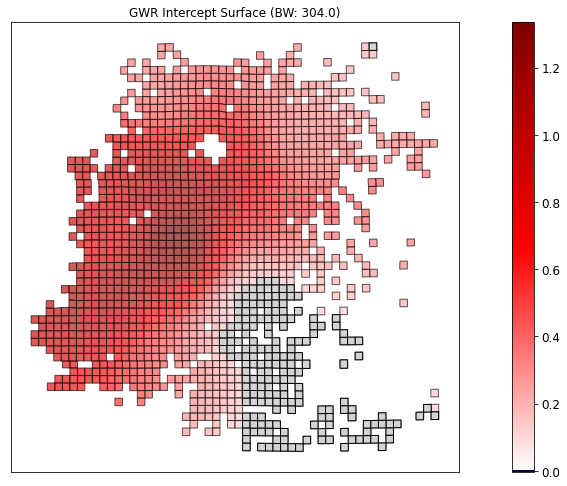

In [142]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = sections_gdf_clean['gwr_x0'].min()
gwr_max = sections_gdf_clean['gwr_x0'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
sections_gdf_clean.plot('gwr_x0', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,0] == 0).any():
    sections_gdf_clean[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

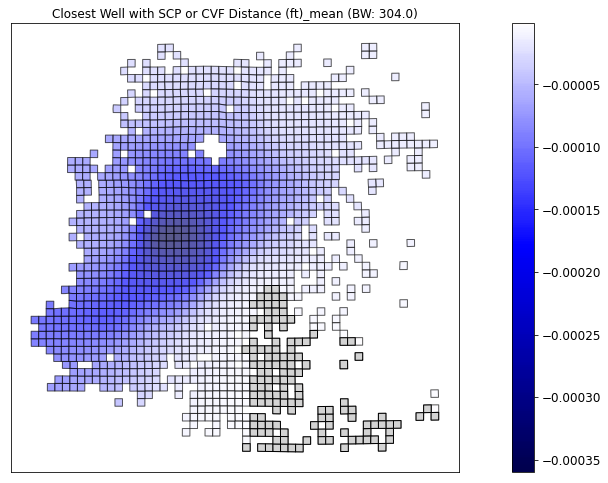

In [143]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('Closest Well with SCP or CVF Distance (ft)_mean (BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = sections_gdf_clean['gwr_x1'].min()
gwr_max = sections_gdf_clean['gwr_x1'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
sections_gdf_clean.plot('gwr_x1', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,1] == 0).any():
    sections_gdf_clean[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()


C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\mgwr\utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


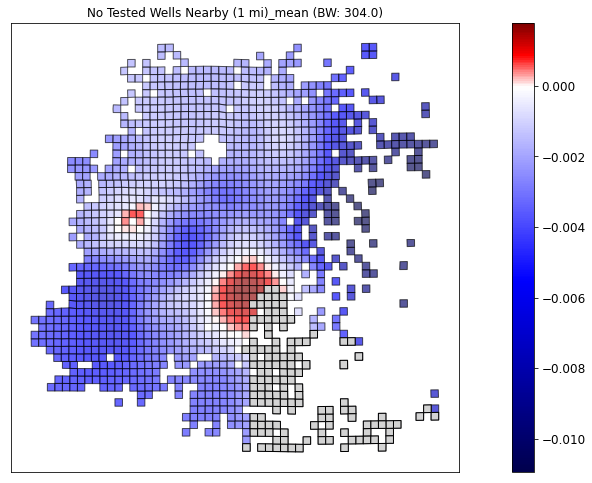

In [144]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('No Tested Wells Nearby (1 mi)_mean (BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = sections_gdf_clean['gwr_x2'].min()
gwr_max = sections_gdf_clean['gwr_x2'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
sections_gdf_clean.plot('gwr_x2', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,1] == 0).any():
    sections_gdf_clean[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()


C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\mgwr\utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


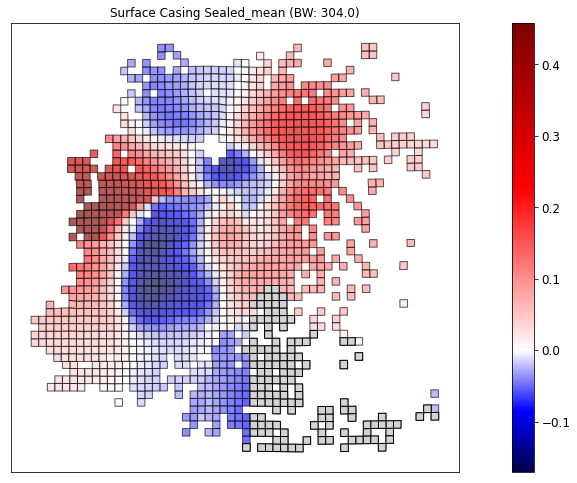

In [145]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('Surface Casing Sealed_mean (BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = sections_gdf_clean['gwr_x3'].min()
gwr_max = sections_gdf_clean['gwr_x3'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
sections_gdf_clean.plot('gwr_x3', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,1] == 0).any():
    sections_gdf_clean[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\mgwr\utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


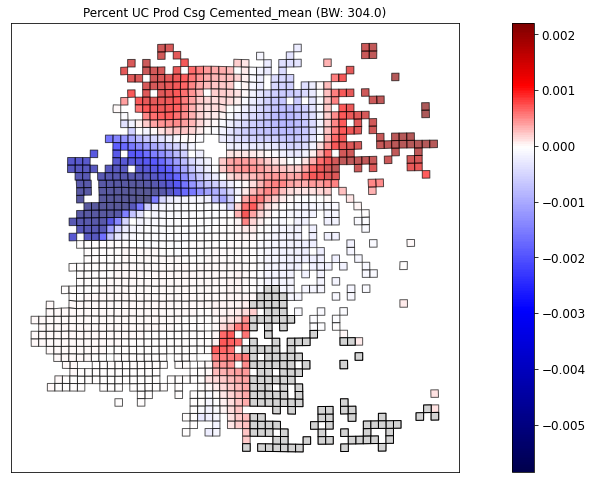

In [146]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('Percent UC Prod Csg Cemented_mean (BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = sections_gdf_clean['gwr_x4'].min()
gwr_max = sections_gdf_clean['gwr_x4'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
sections_gdf_clean.plot('gwr_x4', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,1] == 0).any():
    sections_gdf_clean[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\mgwr\utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


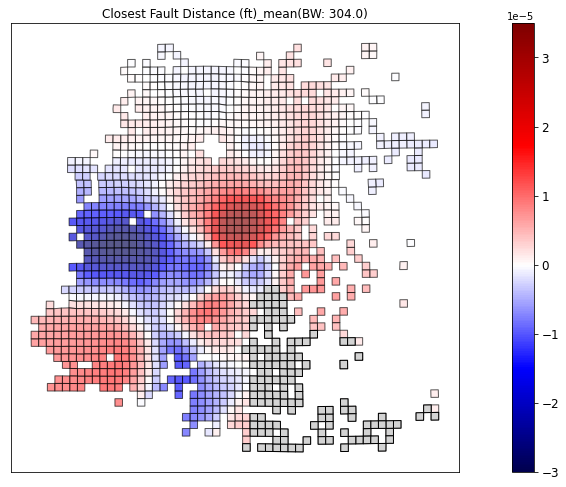

In [147]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('Closest Fault Distance (ft)_mean(BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = sections_gdf_clean['gwr_x5'].min()
gwr_max = sections_gdf_clean['gwr_x5'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
sections_gdf_clean.plot('gwr_x5', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,1] == 0).any():
    sections_gdf_clean[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\mgwr\utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


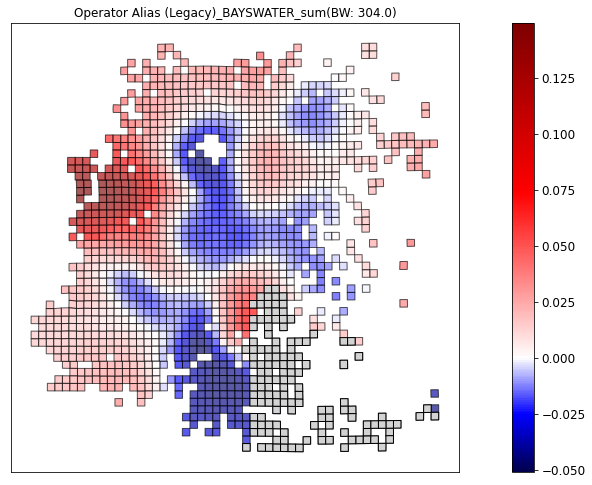

In [148]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('Operator Alias (Legacy)_BAYSWATER_sum(BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = sections_gdf_clean['gwr_x6'].min()
gwr_max = sections_gdf_clean['gwr_x6'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
sections_gdf_clean.plot('gwr_x6', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,1] == 0).any():
    sections_gdf_clean[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

### Prediction

In [149]:
np.random.seed(908)
sample = np.random.choice(range(1504), 300)
mask = np.ones_like(sections_y,dtype=bool).flatten()
mask[sample] = False

cal_coords = np.array(sections_coords)[mask]
cal_y = sections_y[mask]
cal_X = sections_x[mask]
cal_sections_gdf_clean = sections_gdf_clean[mask]

pred_coords = np.array(sections_coords)[~mask]
pred_y = sections_y[~mask]
pred_X = sections_x[~mask]
pred_sections_gdf_clean = sections_gdf_clean[~mask]

In [150]:
gwr_selector = Sel_BW(cal_coords, cal_y, cal_X)
gwr_bw = gwr_selector.search(bw_min=2)
model = GWR(cal_coords, cal_y, cal_X, gwr_bw)
gwr_results = model.fit()

In [151]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

pred_results = model.predict(pred_coords, pred_X, scale, residuals)

In [152]:
sections_gdf_clean.shape

(1504, 37)

In [166]:
# Pearson's R
print('Pearson r: ' + str(np.corrcoef(pred_results.predictions.flatten(), pred_y.flatten())[0][1]))

#MAE
print('MAE: ' +str(sqrt(mean_absolute_error(pred_y.flatten(), pred_results.predictions.flatten()))))

#MSE
print('MSE: ' +str((mean_squared_error(pred_y.flatten(), pred_results.predictions.flatten()))))

#RMSE
print('RMSE: ' +str(sqrt(mean_squared_error(pred_y.flatten(), pred_results.predictions.flatten()))))

Pearson r: 0.6868027849761286
MAE: 0.38716613668105976
MSE: 0.04274278256697949
RMSE: 0.20674327695714675


In [154]:
pred_sections_gdf_clean['Prediction'] = pred_results.predictions
pred_sections_gdf_clean['SCP and/or CVF_mean'] = pred_y

C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


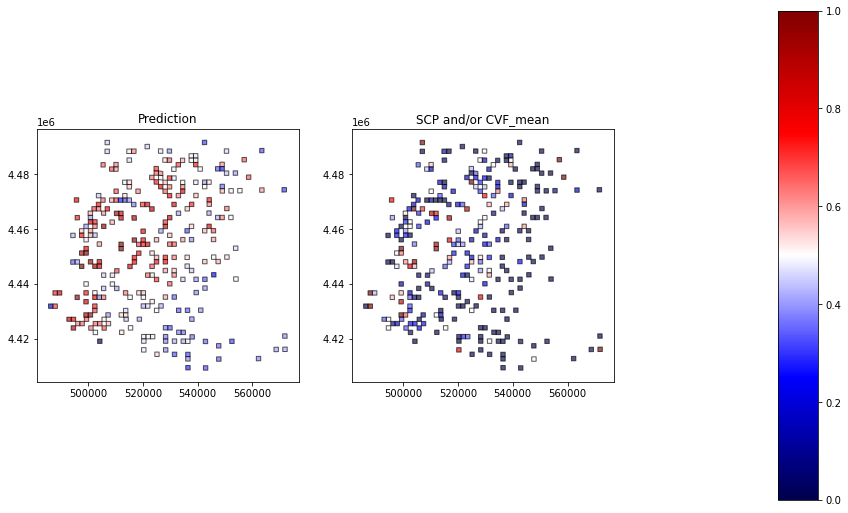

In [162]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,9))
ax[0].set_title('Prediction', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = pred_sections_gdf_clean['Prediction'].min()
gwr_max = pred_sections_gdf_clean['Prediction'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
pred_sections_gdf_clean.plot('Prediction', cmap=sm.cmap, ax=ax[0], vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})

#Prep plot and add axis
ax[1].set_title('SCP and/or CVF_mean', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = pred_sections_gdf_clean['SCP and/or CVF_mean'].min()
gwr_max = pred_sections_gdf_clean['SCP and/or CVF_mean'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
pred_sections_gdf_clean.plot('SCP and/or CVF_mean', cmap=sm.cmap, ax=ax[1], vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})

#Set figure options and plot 
ax[2].set_aspect(12)
cax = ax[2]
plt.colorbar(sm, cax=cax)

plt.show()

In [ ]:
Use trained model to predict on other data